In [4]:
# intalling all the required libraries
!pip install numpy pandas scikit-learn fairlearn aif360 tensorflow seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 14.2 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [7]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

In [8]:
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
import tensorflow as tf

!pip install "aif360[inFairness]"

pip install 'aif360[inFairness]'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 747.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Loading the dataset
from google.colab import files
def load_dataset():
  uploaded = files.upload()
  filename = list(uploaded.keys())[0]
  df=pd.read_csv(filename)
  bins = [18, 24, 34, 44, 54, float('inf')]
  labels = ['Young Adults', 'Early Career', 'Mid Career', 'Experienced', 'Senior']
  df['Age_Category'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
  df = df[['Age_Category', 'Gender', 'Race', 'University', 'Experience', 'Technical_Skills_Score', 'Hired']]
  df = pd.get_dummies(df, columns=['Age_Category', 'Gender', 'Race', 'University'], drop_first=True)

  return df


In [14]:
def plotting():
   df=load_dataset()
   df['Gender_Male'] = df['Gender_Male'].map({True: 'Male', False: 'Female'})
   gender_hiring = df.groupby('Gender_Male')['Hired'].value_counts(normalize=True).unstack()
   fig, ax = plt.subplots(figsize=(7, 5))
   gender_hiring.plot(kind='bar', stacked=True, colormap="coolwarm", ax=ax)
   plt.title("Hiring Distribution by Gender", fontsize=14, fontweight='bold')
   plt.ylabel("Proportion of Hiring", fontsize=12)
   plt.xlabel("Gender", fontsize=12)
   plt.xticks(rotation=0, fontsize=11)
   plt.legend(["Not Hired", "Hired"], title="Status", fontsize=10)
   for i in ax.containers:
       ax.bar_label(i, fmt="%.2f", label_type="center", fontsize=10, color="black")
   plt.show()


In [9]:
def standard_split(df):
  x=df.drop(columns=['Hired'])
  y=df['Hired']
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
  scaler = StandardScaler()
  x_train = scaler.fit_transform(x_train)
  x_test=scaler.transform(x_test)
  return x_train,x_test,y_train,y_test,df


In [10]:
def model_training(x_train,x_test,y_train,y_test):
  models={
      "Logistic Regression": LogisticRegression(),
      "Random Forest": RandomForestClassifier(),
      "Isolation Forest": IsolationForest()
  }
  results={}
  for name,model in models.items():
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    results[name]=accuracy_score(y_test,y_pred)
  return models,results


In [11]:
def bias_fairlearn(models,x_train,x_test,y_train,y_test):
  bias_metrics={}
  for name,model in models.items():

    exp_grad=ExponentiatedGradient(model,constraints=DemographicParity())
    exp_grad.fit(x_train,y_train,sensitive_features=x_train[:,0])
    y_fair_pred=exp_grad.predict(x_test)

    dpd_before=demographic_parity_difference(y_test,y_fair_pred,sensitive_features=x_test[:,0])
    eod_before=equalized_odds_difference(y_test,y_fair_pred,sensitive_features=x_test[:,0])

    dpd_after=demographic_parity_difference(y_test,y_fair_pred,sensitive_features=x_test[:,0])
    eod_after=equalized_odds_difference(y_test,y_fair_pred,sensitive_features=x_test[:,0])

    bias_score_before = (dpd_before + eod_before) / 2
    bias_score_after = (dpd_after + eod_after) / 2

    acc_before = accuracy_score(y_test, model.predict(x_test))
    acc_after = accuracy_score(y_test, y_fair_pred)

    bias_metrics[name] = {
            "bias_score_before": bias_score_before,
            "bias_score_after": bias_score_after,
            "acc_before": acc_before,
            "acc_after": acc_after
        }


  return bias_metrics

In [ ]:
df=load_dataset()
x_train,x_test,y_train,y_test,df=standard_split(df)
models,accuracy_results=model_training(x_train,x_test,y_train,y_test)
fairlearn_results=bias_fairlearn(models,x_train,x_test,y_train,y_test)
fairlearn_results

Saving Highly_Biased_Hiring_Dataset.csv to Highly_Biased_Hiring_Dataset.csv


{'Logistic Regression': {'bias_score_before': np.float64(0.23436775790651992),
  'bias_score_after': np.float64(0.23436775790651992),
  'acc_before': 0.5915,
  'acc_after': 0.5785},
 'Random Forest': {'bias_score_before': np.float64(0.32755570255570254),
  'bias_score_after': np.float64(0.32755570255570254),
  'acc_before': 0.6125,
  'acc_after': 0.611},
 'Isolation Forest': {'bias_score_before': np.float64(0.3216945174492344),
  'bias_score_after': np.float64(0.3216945174492344),
  'acc_before': 0.1325,
  'acc_after': 0.596}}

In [12]:
def bias_aif360(df, models, x_train, x_test,y_train, y_test):
    privileged_groups = [{'Gender_Male': 1}]
    unprivileged_groups = [{'Gender_Male': 0}]

    dataset = StandardDataset(df, label_name='Hired', protected_attribute_names=['Gender_Male'], privileged_classes=[[1]],favorable_classes=[1])

    bias_metrics = {}

    for name, model in models.items():
        # Train and predict before mitigation
        model.fit(x_train, y_train)
        y_pred_before = model.predict(x_test)

        # Compute fairness metrics before mitigation
        metric_before = ClassificationMetric(dataset, dataset, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
        dpd_before = metric_before.statistical_parity_difference()
        eod_before = metric_before.equal_opportunity_difference()
        bias_score_before = (dpd_before + eod_before) / 2

        # Apply reweighing mitigation
        reweighing = Reweighing(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
        dataset_transf = reweighing.fit_transform(dataset)

        # Retrain the model after mitigation
        model.fit(x_train, y_train)
        y_pred_after = model.predict(x_test)

        # Compute fairness metrics after mitigation
        metric_after = ClassificationMetric(dataset_transf, dataset_transf, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
        dpd_after = metric_after.statistical_parity_difference()
        eod_after = metric_after.equal_opportunity_difference()
        bias_score_after = (dpd_after + eod_after) / 2

        # Compute accuracy before and after mitigation
        acc_before = accuracy_score(y_test, y_pred_before)
        acc_after = accuracy_score(y_test, y_pred_after)

        bias_metrics[name] = {
            "bias_score_before": bias_score_before,
            "bias_score_after": bias_score_after,
            "acc_before": acc_before,
            "acc_after": acc_after
        }

    return bias_metrics


In [ ]:
# Displaying results
df = load_dataset()
x_train, x_test, y_train, y_test, df = standard_split(df)
models, accuracy_results = model_training(x_train, x_test, y_train, y_test)
fairlearn_results = bias_fairlearn(models,x_train,x_test,y_train, y_test)
aif360_results = bias_aif360(df,models,x_train,x_test,y_train,y_test)
print("Hiring Vs Grender\n")
plotting()
# Displaying results
print("Fairlearn Bias Metrics (Before & After Mitigation) for Each Model:")
for model, results in fairlearn_results.items():
   print(f"{model}: \nBias Score Before: {results['bias_score_before']}, \nBias Score After: {results['bias_score_after']}, \nAccuracy Before: {results['acc_before']}, \nAccuracy After: {results['acc_after']}")
   print("\n")

print("\nAIF360 Bias Metrics (Before & After Mitigation) for Each Model:")
for model, results in aif360_results.items():
    print(f"{model}: \nBias Score Before: {results['bias_score_before']}, \nBias Score After: {results['bias_score_after']}, \nAccuracy Before: {results['acc_before']}, \nAccuracy After: {results['acc_after']}")
    print("\n")

Saving Highly_Biased_Hiring_Dataset.csv to Highly_Biased_Hiring_Dataset (1).csv


/usr/local/lib/python3.11/dist-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


Fairlearn Bias Metrics (Before & After Mitigation) for Each Model:
Logistic Regression: 
Bias Score Before: 0.2512546322467182, 
Bias Score After: 0.2512546322467182, 
Accuracy Before: 0.5915, 
Accuracy After: 0.5665


Random Forest: 
Bias Score Before: 0.2780095952265763, 
Bias Score After: 0.2780095952265763, 
Accuracy Before: 0.6115, 
Accuracy After: 0.608


Isolation Forest: 
Bias Score Before: 0.37217991500527653, 
Bias Score After: 0.37217991500527653, 
Accuracy Before: 0.176, 
Accuracy After: 0.602



AIF360 Bias Metrics (Before & After Mitigation) for Each Model:
Logistic Regression: 
Bias Score Before: -0.07773473752168825, 
Bias Score After: 0.0, 
Accuracy Before: 0.5915, 
Accuracy After: 0.5915


Random Forest: 
Bias Score Before: -0.07773473752168825, 
Bias Score After: 0.0, 
Accuracy Before: 0.615, 
Accuracy After: 0.6115


Isolation Forest: 
Bias Score Before: -0.07773473752168825, 
Bias Score After: 0.0, 
Accuracy Before: 0.155, 
Accuracy After: 0.188




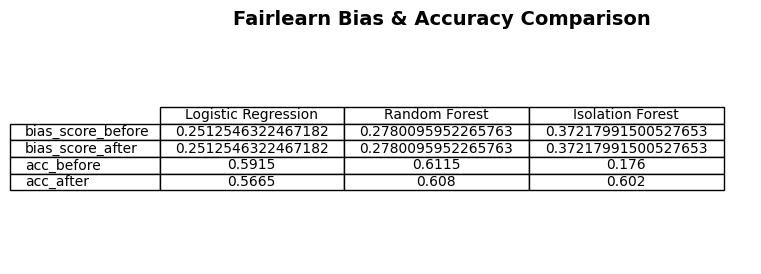

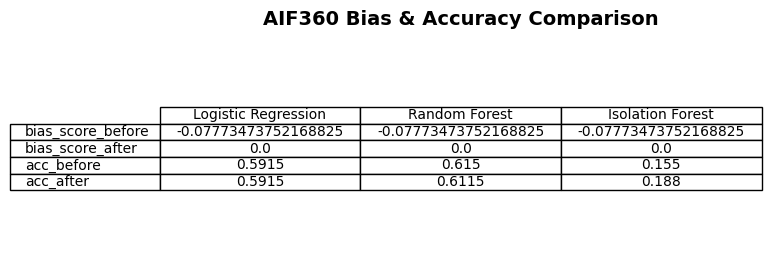

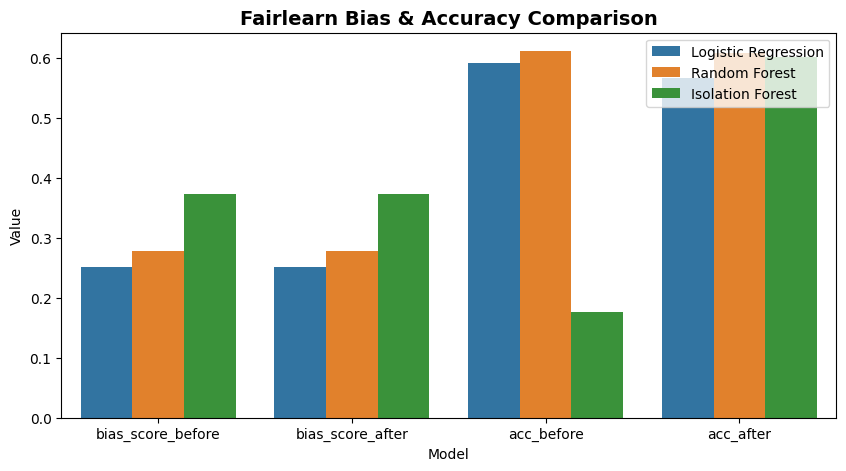

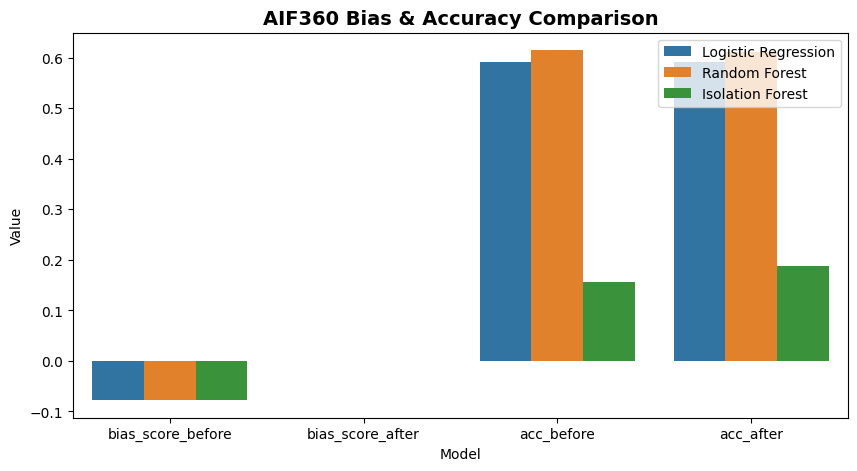

In [ ]:
# Assuming your computed results are stored in these DataFrames
# Replace these with the actual DataFrames generated from your model output
fairlearn_results_df = pd.DataFrame(fairlearn_results)  # Fetching directly from model output
aif360_results_df = pd.DataFrame(aif360_results)  # Fetching directly from model output

# Function to display table dynamically
def plot_table(df, title):
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.axis("off")

    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([0, 1, 2, 3])

    plt.show()

# Function to generate bar charts dynamically
def plot_comparison(df, title):
    df_melted = df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Value")

    plt.figure(figsize=(10, 5))
    sns.barplot(x="index", y="Value", hue="Metric", data=df_melted)

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Model")
    plt.ylabel("Value")
    plt.legend(loc="upper right")

    plt.show()

# Generate Tables from Dynamic Data
plot_table(fairlearn_results_df, "Fairlearn Bias & Accuracy Comparison")
plot_table(aif360_results_df, "AIF360 Bias & Accuracy Comparison")

# Generate Graphs from Dynamic Data
plot_comparison(fairlearn_results_df, "Fairlearn Bias & Accuracy Comparison")
plot_comparison(aif360_results_df, "AIF360 Bias & Accuracy Comparison")


Saving Highly_Biased_Hiring_Dataset.csv to Highly_Biased_Hiring_Dataset (2).csv


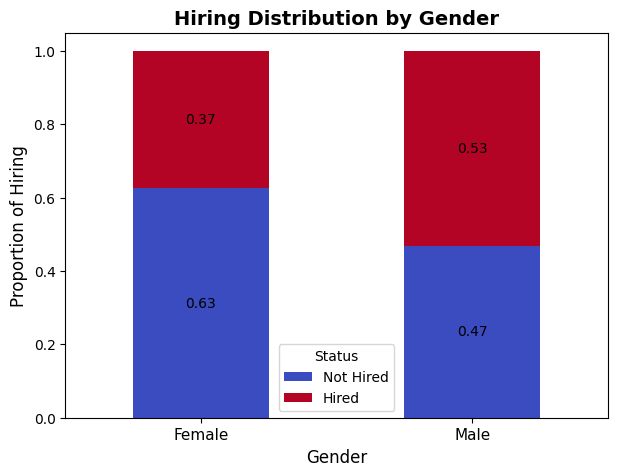

In [ ]:
plotting()

In [ ]:

def load_dataset():
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename)
    bins = [18, 24, 34, 44, 54, float('inf')]
    labels = ['Young Adults', 'Early Career', 'Mid Career', 'Experienced', 'Senior']
    df['Age_Category'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
    df = df[['Age_Category', 'Gender', 'Race', 'University', 'Experience', 'Technical_Skills_Score', 'Hired']]
    df = pd.get_dummies(df, columns=['Age_Category', 'Gender', 'Race', 'University'], drop_first=True)
    return df

def bias_aif360(df, models, x_train, x_test, y_train, y_test):
    privileged_groups = [{'Gender_Male': 1}]
    unprivileged_groups = [{'Gender_Male': 0}]
    dataset = StandardDataset(df, label_name='Hired', protected_attribute_names=['Gender_Male'], privileged_classes=[[1]], favorable_classes=[1])
    reweighing = Reweighing(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    dataset_transf = reweighing.fit_transform(dataset)
    df_mitigated = pd.DataFrame(dataset_transf.convert_to_dataframe()[0])
    df_mitigated.to_csv("Mitigated_Hiring_Dataset.csv", index=False)
    print("Bias-mitigated dataset saved as Mitigated_Hiring_Dataset.csv")
    return df_mitigated

def download_file():
    files.download("Mitigated_Hiring_Dataset.csv")

df = load_dataset()
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['Hired']), df['Hired'], test_size=0.2, random_state=42)
models = {"Logistic Regression": LogisticRegression(), "Random Forest": RandomForestClassifier(), "Isolation Forest": IsolationForest()}
for name, model in models.items():
    model.fit(x_train, y_train)

df_mitigated = bias_aif360(df, models, x_train, x_test, y_train, y_test)
download_file()


Saving Highly_Biased_Hiring_Dataset.csv to Highly_Biased_Hiring_Dataset (6).csv


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bias-mitigated dataset saved as Mitigated_Hiring_Dataset.csv


/usr/local/lib/python3.11/dist-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>